## Задание 7

In [1]:
import numpy as np
import codecs
import scipy.stats as st

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

Создадим функцию для считывания файла и создания массива вероятностей каждой длины слова. Сначала из текста удаляются знаки препинания, а потом он делится на слова по пробельным символам. При этом сложные слова с дефисом типа "генерал-майор" принимаются за одно слово, как и есть по правилам русского языка.

In [3]:
def file_to_dist(filename):
    if filename in ['./eng.txt', './news.2008.ru.shuffled']:
        filep = codecs.open(filename, 'r', 'utf_8_sig')
    else:
        filep = open(filename)
    new_doc = filep.read()
    filep.close()
    words = new_doc.replace("“",'').replace("”",'').replace(".",'').replace(",",'').replace(";",'').replace(":",'').replace("\"",'').replace("?",'').replace("!",'').replace("0x98",'').split()
    lengths = []
    max_len = 0
    for word in words:
        cur_len = len(word)
        lengths.append(cur_len)
        if cur_len > max_len:
            max_len = cur_len
    counts = np.zeros(max_len)
    for i in range(0,max_len):
        counts[i] = lengths.count(i+1)
    return counts, lengths

Применим эту функцию к каждому из текстов.

In [4]:
news, w_news = file_to_dist('./news.2008.ru.shuffled')  
rus, w_rus = file_to_dist('./rus.txt')
fra, w_fra = file_to_dist('./fra.txt')
eng, w_eng = file_to_dist('./eng.txt')

### Часть первая
Оценим параметры распеределений по методу наибольшего правдоподобия.
Для этого определим соответствующую функцию и максимизируем ее с помощью производной.

$\mathrm{log}L(\lambda)=\sum\limits_{i=0}^{\infty} k_i \mathrm{log} p_i(\lambda) = N\sum\limits_{i=0}^{\infty} \hat{p}_i (-\lambda +i\mathrm{log}\lambda -\mathrm{log} i!)$

Отбросим постоянный множитель $N$ и, продифференцировав, получим условие максимума:

$\sum\limits_{i=0}^{\infty} \hat{p}_i (\dfrac{i}{\lambda} - 1) = \sum\limits_{i=0}^{\infty} \dfrac{i\hat{p}_i}{\lambda} - 1 = 0$

Откуда $\lambda = \sum\limits_{i=0}^{\infty} i\hat{p}_i$

In [5]:
la_ml_news = np.sum(news*(np.array(range(0,len(news)))+1))/np.sum(news)
la_ml_rus = np.sum(rus*(np.array(range(0,len(rus)))+1))/np.sum(rus)
la_ml_eng = np.sum(eng*(np.array(range(0,len(eng)))+1))/np.sum(eng)
la_ml_fra = np.sum(fra*(np.array(range(0,len(fra)))+1))/np.sum(fra)
la_ml_news, la_ml_rus, la_ml_eng, la_ml_fra

(6.127607946569107, 4.837898143659642, 4.393594379348224, 5.027213568931914)

Возникает предположение: параметр распределения Пуассона (он равен средней длине слова) для новостей больше, чем для художественного текста; в английском языке он меньше, чем в русском и во французском; а вот между русским и французским языками разница незначительна --- возможно, гипотеза о совпадении данных параметров не будет отвергнута.

### Часть вторая

Проверка гипотез 

$H_0$: $\lambda_{news} = \lambda_{rus}$ против односторонней альтернативы $H_1$: $\lambda_{news} > \lambda_{rus}$

$H_0$: $\lambda_{fra} = \lambda_{rus}$ против двусторонней альтернативы $H_1$: $\lambda_{fra} \not= \lambda_{rus}$

$H_0$: $\lambda_{eng} = \lambda_{rus}$ против двусторонней альтернативы $H_1$: $\lambda_{eng} \not= \lambda_{rus}$

Альтернатива в первом случае односторонняя, потому что знак неравенства можно предсказать из общих соображений: в новостях значительно больше составных слов, терминов и т. п..

Для проверки будем использовать критерий $\chi$-квадрат, потому что это стандартный метод проверки соответствия действительного распределения ожидаемому.

Найдем первый ноль в распределениях; считать будем только до него.

In [6]:
n_news = len(news)
for i in range(0,len(news)):
    if news[i] == 0:
        n_news = i
        break
n_rus = len(rus)
for i in range(0,len(rus)):
    if rus[i] == 0:
        n_rus = i
        break
n_eng = len(eng)
for i in range(0,len(eng)):
    if eng[i] == 0:
        n_eng = i
        break
n_fra = len(fra)
for i in range(0,len(fra)):
    if fra[i] == 0:
        n_fra = i
        break
n_news, n_rus, n_eng, n_fra

(29, 25, 25, 22)

Русская "Анна Каренина" и новости

In [7]:
st.chisquare(rus[:n_rus], news[:n_rus]/np.sum(news[:n_rus])*np.sum(rus[:n_rus]))

Power_divergenceResult(statistic=41594.53039019087, pvalue=0.0)

Русский и французский тексты

In [8]:
st.chisquare(fra[:n_fra], rus[:n_fra]/np.sum(rus[:n_fra])*np.sum(fra[:n_fra]))

Power_divergenceResult(statistic=26392.32547503147, pvalue=0.0)

Русский и английский тексты

In [9]:
st.chisquare(eng[:n_eng], rus[:n_eng]/np.sum(rus[:n_eng])*np.sum(eng[:n_eng]))

Power_divergenceResult(statistic=128808.44710994551, pvalue=0.0)

Получили, что $\chi$-квадрат критерий во всех случаях отвергает гипотезу о равенстве распределений. Что неудивительно, учитывая огромное количество слов и относительно малое количество классов: даже малое отклонение вероятности приводит к значительному увеличению статистики. 

То есть, все гипотезы о равенстве распределений отвергнуты. Но этому результату, по указанной выше причине, доверять нельзя.

## Часть третья

Другой способ: проверка равенства распределений по критерию Колмогорова-Смирнова. Его применение уже не зависит от количества слов, а только от доли слов каждой длины.

Русская "Анна Каренина" и новости

In [10]:
st.ks_2samp(rus/rus.sum(), news/news.sum())

Ks_2sampResult(statistic=0.2636409994900561, pvalue=0.08005497778507562)

Русский и английский тексты

In [11]:
st.ks_2samp(rus/rus.sum(), eng/eng.sum())

Ks_2sampResult(statistic=0.27135135135135136, pvalue=0.18695226951336133)

Русский и французский тексты

In [12]:
st.ks_2samp(rus/rus.sum(), fra/fra.sum())

Ks_2sampResult(statistic=0.24790307548928242, pvalue=0.23331949097837165)

Английский и французский тексты

In [13]:
st.ks_2samp(eng/eng.sum(), fra/fra.sum())

Ks_2sampResult(statistic=0.1613793103448276, pvalue=0.8430803096070419)

Таким образом, критерий Колмогорова-Смирнова не позволяет отвергнуть гипотезы о равенстве распределений.

## Часть четвертая

Возникло желание проверить соответствие распределению Пуассона.

Построим гистограммы для наших распределений и сравним распределение с пуассоновским при помощи критерия Колмогорова-Смирнова.

In [14]:
from scipy.stats import poisson as P

Новости на русском языке

In [15]:
teor = P.pmf(np.array(range(0,len(news))),la_ml_news)
st.ks_2samp(news/news.sum(),teor)

Ks_2sampResult(statistic=0.39622641509433965, pvalue=0.0003063174696923859)

(array([39.,  2.,  1.,  1.,  0.,  1.,  2.,  3.,  0.,  4.]),
 array([0.        , 0.01120211, 0.02240422, 0.03360633, 0.04480844,
        0.05601055, 0.06721266, 0.07841477, 0.08961688, 0.10081899,
        0.1120211 ]),
 <a list of 10 Patch objects>)

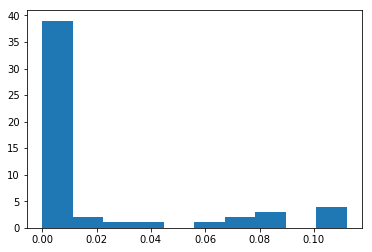

In [16]:
plt.hist(news/news.sum())

Русский текст "Анны Карениной"

In [17]:
teor = P.pmf(np.array(range(0,len(rus))),la_ml_rus)
st.ks_2samp(rus/rus.sum(),teor)

Ks_2sampResult(statistic=0.3243243243243243, pvalue=0.031221390390705664)

(array([26.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  1.]),
 array([0.        , 0.01488708, 0.02977416, 0.04466124, 0.05954832,
        0.0744354 , 0.08932248, 0.10420956, 0.11909664, 0.13398372,
        0.1488708 ]),
 <a list of 10 Patch objects>)

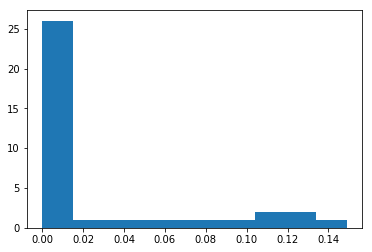

In [18]:
plt.hist(rus/rus.sum())

Французский перевод

In [19]:
teor = P.pmf(np.array(range(0,len(fra))),la_ml_fra)
st.ks_2samp(fra/fra.sum(),teor)

Ks_2sampResult(statistic=0.27586206896551724, pvalue=0.1844295421178442)

(array([19.,  2.,  2.,  1.,  2.,  2.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.02277999, 0.04555998, 0.06833996, 0.09111995,
        0.11389994, 0.13667993, 0.15945992, 0.1822399 , 0.20501989,
        0.22779988]),
 <a list of 10 Patch objects>)

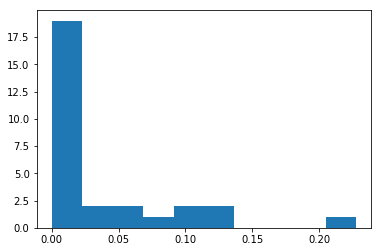

In [20]:
plt.hist(fra/fra.sum())

Английский перевод

In [21]:
teor = P.pmf(np.array(range(0,len(eng))),la_ml_eng)
st.ks_2samp(eng/eng.sum(),teor)

Ks_2sampResult(statistic=0.28, pvalue=0.237010099316509)

(array([16.,  3.,  2.,  0.,  1.,  0.,  2.,  0.,  0.,  1.]),
 array([2.86067375e-06, 2.61216702e-02, 5.22404797e-02, 7.83592892e-02,
        1.04478099e-01, 1.30596908e-01, 1.56715718e-01, 1.82834527e-01,
        2.08953337e-01, 2.35072146e-01, 2.61190956e-01]),
 <a list of 10 Patch objects>)

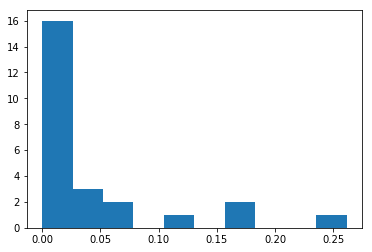

In [22]:
plt.hist(eng/eng.sum())

Результаты оказались неожиданными. Гистограммы не очень похожи на распределение Пуассона. 

Для текстов на английском и французском языках гипотеза принята на уровне значимости 0.05. А вот для обоих текстов на русском языке она отвергнута на уровне значимости 0.05. То есть, длины слов не подчиняются распределению Пуассона с параметром, найденным методом наибольшего правдоподобия!

## Часть пятая

Найдем интервальные оценки для параметров распределений с помощью бутспрепа.

Случайно перемешиваем выборки длин и берем лишь относительно небольшое число элементов, достаточное для семплирования, так как при случайном выборе распределение подвыборки (в пределе) соответствует распределению выборки.

In [23]:
from arch.bootstrap import IIDBootstrap
from random import shuffle

Поскольку для распределения Пуассона параметр равен математическому ожиданию, будем использовать среднее значение.

Доверительные интервалы для русского текста в зависимости от количества взятых слов:

[[4.80900858]
 [4.87718619]]


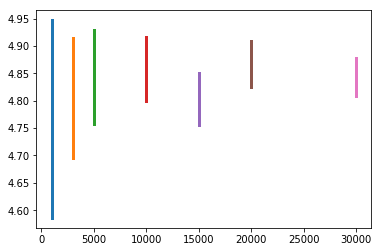

In [24]:
for N in [1000, 3000, 5000, 10000, 15000, 20000, 30000]:
    shuffle(w_rus)
    bs = IIDBootstrap(np.array(w_rus[:N]))
    ci = bs.conf_int(np.mean, 5000, size=0.95, method='bca')
    plt.plot([N,N], ci, lw=3)
print(ci)

Полученная ранее точечная оценка $\lambda_{rus} = 4.84$ попадает во все найденные интервалы.

Доверительные интервалы для английского текста в зависимости от количества взятых слов:

[[4.36773333]
 [4.42234046]]


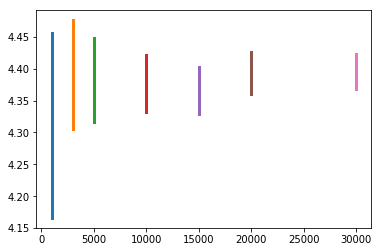

In [25]:
for N in [1000, 3000, 5000, 10000, 15000, 20000, 30000]:
    shuffle(w_eng)
    bs = IIDBootstrap(np.array(w_eng[:N]))
    ci = bs.conf_int(np.mean, 5000, size=0.95, method='bca')
    plt.plot([N,N], ci, lw=3)
print(ci)

Полученная ранее точечная оценка $\lambda_{eng} = 4.39$ попадает во все найденные интервалы.

Доверительные интервалы для французского текста в зависимости от количества взятых слов:

[[4.98930405]
 [5.05686667]]


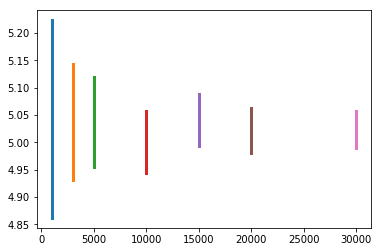

In [26]:
for N in [1000, 3000, 5000, 10000, 15000, 20000, 30000]:
    shuffle(w_fra)
    bs = IIDBootstrap(np.array(w_fra[:N]))
    ci = bs.conf_int(np.mean, 5000, size=0.95, method='bca')
    plt.plot([N,N], ci, lw=3)
print(ci)

Полученная ранее точечная оценка $\lambda_{fra} = 5.02$ попадает во все найденные интервалы.

Доверительные интервалы для новостей в зависимости от количества взятых слов:

[[6.06868713]
 [6.14973169]]


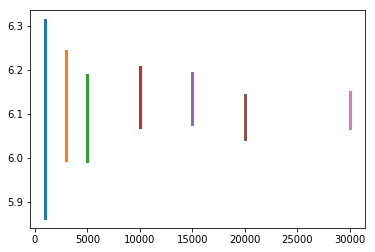

In [27]:
for N in [1000, 3000, 5000, 10000, 15000, 20000, 30000]:
    shuffle(w_news)
    bs = IIDBootstrap(np.array(w_news[:N]))
    ci = bs.conf_int(np.mean, 5000, size=0.95, method='bca')
    plt.plot([N,N], ci, lw=3)
print(ci)

Полученная ранее точечная оценка $\lambda_{news} = 6.13$ попадает во все найденные интервалы.

Несложно заметить, что 95% доверительные интервалы для разных текстов не пересекаются.

# Выводы

1. Выяснено, что критерий хи-квадрат не дает адекватного результата на рассмотренных текстах. С помощью критерия Колмогорова-Смирнова на уровне значимости 0.05 гипотеза одинакового распределения длин не отвергнута как для текстов на разных языках, так и для разных жанров на русском языке.

2. Получены точечные оценки методом наибольшего правдоподобия для параметра $\lambda$ в предположении, что длины слов подчиняются распределению Пуассона: 4.84 для русского художественного текста, 4.39 --- для английского, 5.02 --- для французского и 6.13 для новостей.

3. Получены 95% доверительные интервалы для этих оценок: соответственно, [4.81, 4.88], [4.37, 4.42], [4.99, 5.06], [6.07, 6.15] (в том же порядке). Интервалы не пересекаются, поэтому на данном уровне доверия можно утверждать, что параметры различны.

4. Таким образом, можно сделать вывод: все полученные распределения отличаются параметром, который равен средней длине слова. В целом, полученные значения согласуются с найденными в теоретических источниках: в русском языке 4.9 символов на слово и 5.9 --- в газетах (5.13 в среднем). В английском языке 4.24 символа на слово, во французском --- 5 символов на слово.